<a href="https://colab.research.google.com/github/mkbahk/AmazonBraket/blob/main/Qiskit_Runtime_QPU_Sampler_Primitives_get_counts__mkbahk_20241010.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

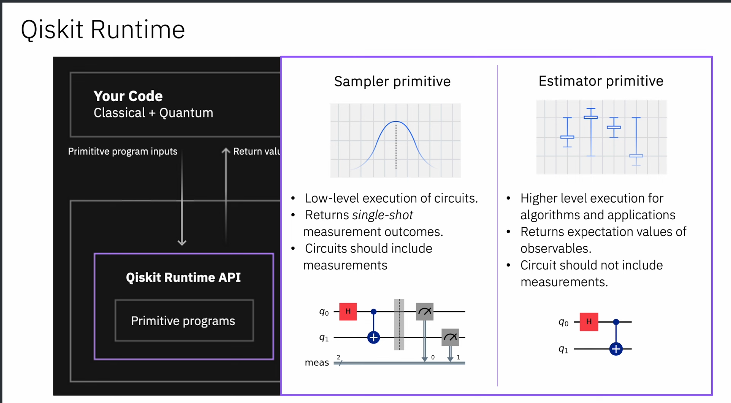

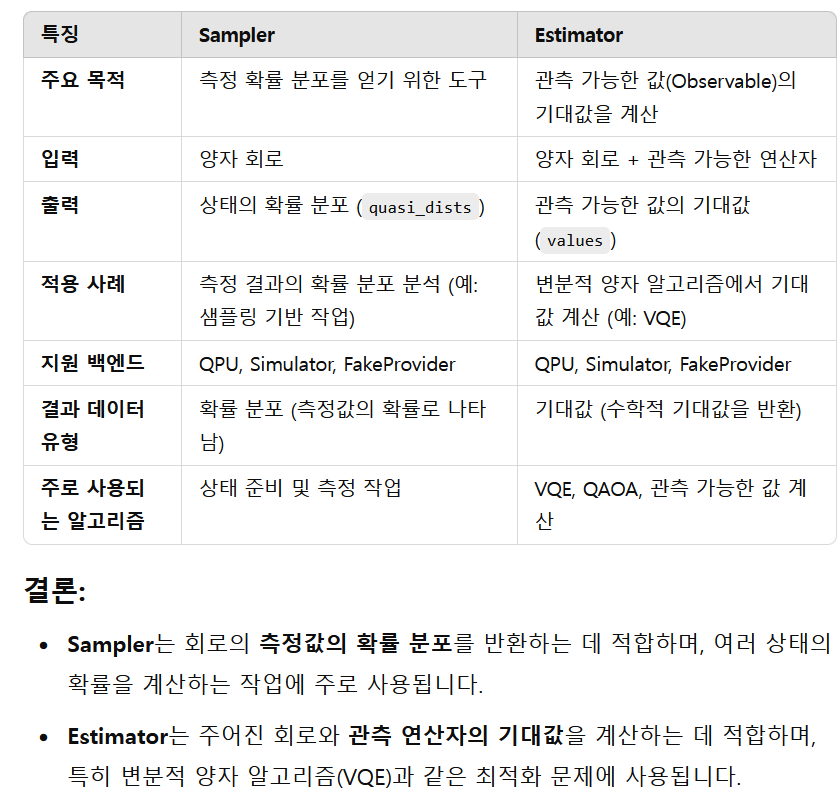

In [ ]:
### Qiskit 설치: Windows, 클라우드 환경 ###
%pip install qiskit[visualization]==1.2.4
#%pip install qiskit-ibm-runtime==0.31.0
%pip install qiskit-ibm-runtime==0.30.0
%pip install qiskit-transpiler-service==0.4.10
%pip install qiskit-aer==0.15.1

In [ ]:
%pip show qiskit qiskit-ibm-runtime qiskit-transpiler-service qiskit-aer

Name: qiskit
Version: 1.2.4
Summary: An open-source SDK for working with quantum computers at the level of extended quantum circuits, operators, and primitives.
Home-page: https://www.ibm.com/quantum/qiskit
Author: 
Author-email: Qiskit Development Team <qiskit@us.ibm.com>
License: Apache 2.0
Location: /usr/local/lib/python3.10/dist-packages
Requires: dill, numpy, python-dateutil, rustworkx, scipy, stevedore, symengine, sympy, typing-extensions
Required-by: qiskit-aer, qiskit-ibm-runtime, qiskit-qasm3-import, qiskit-transpiler-service
---
Name: qiskit-ibm-runtime
Version: 0.30.0
Summary: IBM Quantum client for Qiskit Runtime.
Home-page: https://github.com/Qiskit/qiskit-ibm-runtime
Author: Qiskit Development Team
Author-email: qiskit@us.ibm.com
License: Apache 2.0
Location: /usr/local/lib/python3.10/dist-packages
Requires: ibm-platform-services, numpy, pydantic, python-dateutil, qiskit, requests, requests-ntlm, urllib3, websocket-client
Required-by: 
---
Name: qiskit-transpiler-service


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from qiskit import QuantumCircuit, transpile
from qiskit.quantum_info import Statevector, Operator, SparsePauliOp
from qiskit.primitives import Estimator as QEstimator, Sampler as QSampler, StatevectorSampler, PrimitiveJob
#DeprecationWarning: The class ``qiskit.primitives.sampler.Sampler`` is deprecated as of qiskit 1.2.
#It will be removed no earlier than 3 months after the release date.
#All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts.
#The V2 alternative for the `Sampler` class is `StatevectorSampler`.

from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

from qiskit_ibm_runtime import QiskitRuntimeService, SamplerV2 as RSampler, EstimatorV2 as REstimator, Session, Options
from qiskit_ibm_runtime.fake_provider import FakeManilaV2, FakeBrisbane

from qiskit_aer import AerSimulator
from qiskit_aer.primitives import SamplerV2 as AerSampler, EstimatorV2 as AerEstimator

from qiskit.visualization import plot_histogram, plot_state_city, plot_state_paulivec, plot_state_hinton


In [ ]:
# Connecting runtime account
service = QiskitRuntimeService(channel="ibm_quantum", token="659ca3f608d45d6ed9df8a0832309ab782fa9e57299d0c8bc2bdb22a96503d17f03c072a0475ed47531ac4b332685571f6125b45a13b314ea5be7f1aec4bdb19")
#service.save_account(channel="ibm_quantum", token="YOUR_API_TOKEN")
#backends = service.least_busy(min_num_qubits=2)
#service.backends("ibm_brisbane")
backends=service.backends()
print(backends)

[<IBMBackend('ibm_brisbane')>, <IBMBackend('ibm_kyiv')>, <IBMBackend('ibm_sherbrooke')>]


In [ ]:
backend=service.backends()[0]
print(backend)

<IBMBackend('ibm_brisbane')>


In [ ]:
# Bell 상태 생성 회로 작성
qc = QuantumCircuit(2, 2)
qc.h(0)           # 큐빗 0에 Hadamard 게이트
qc.cx(0, 1)       # 큐빗 0에서 큐빗 1로 CNOT 게이트
qc.measure([0, 1], [0, 1])  # 두 큐빗을 측정

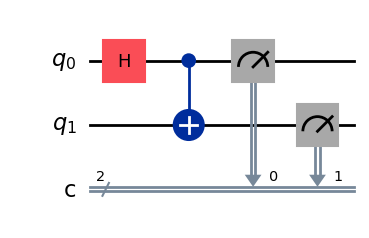

In [ ]:
qc.draw('mpl')

In [ ]:
#sampler = QSampler(backend)
sampler = RSampler(backend)
#sampler = FakeManilaV2()
#sampler = AerSampler()

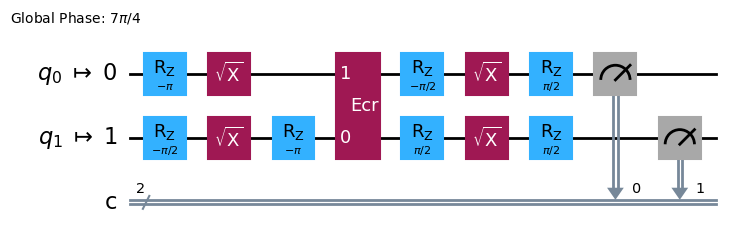

In [ ]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
# Convert to an ISA circuit and layout-mapped observables.
pm = generate_preset_pass_manager(backend=backend, optimization_level=1)
isa_circuit = pm.run(qc)

isa_circuit.draw('mpl', idle_wires=False)

Qiskit-runtime-Service는 이전의 확률분포 반환에서 추가적으로 데이터를 반환하는 두 가지 방법을 제공합니다.
1.   측정하기로 선택한 큐비트 집합에 대한 확률 분포

```
# 회로 실행 및 결과 얻기
job = sampler.run(circuit)
result = job.result()
counts = result.quasi_dists[0]
# 결과 출력
print(counts)
```

2.   관측 가능한 값의 기대값

```
# 회로 실행 및 결과 얻기
job = estimator.run(observable, circuit)
result = job.result()
expectation_value = result.values[0]
# 결과 출력
print(expectation_value)
```


In [ ]:
job = sampler.run([isa_circuit], shots=1024)

# Use the job ID to retrieve your job data later
print(f">>> Job ID: {job.job_id()}")

# 서비스 플렛폼에서 Job이 완료될 때까지 기다립니다.

>>> Job ID: cw7hft79ezk00080w6b0


In [ ]:
### 서비스 플렛폼에서 Job이 완료되면 그 Job.ID를 이용해 결과를 추출합니다. ###
job = service.job("cw7hft79ezk00080w6b0")

result = job.result()

In [ ]:
result

PrimitiveResult([PubResult(data=DataBin(c=BitArray(<shape=(), num_shots=1024, num_bits=2>)), metadata={'circuit_metadata': {}})], metadata={'execution': {'execution_spans': ExecutionSpans([SliceSpan(<start='2024-10-16 01:40:22', stop='2024-10-16 01:51:05', size=1024>)])}, 'version': 2})

In [ ]:
result[0].data.c.get_counts()

{'11': 509, '00': 423, '10': 34, '01': 58}

In [ ]:
# 1. PubResult 객체에 접근
#pub_result = result[0]  # 리스트로 감싸져 있으므로 첫 번째 PubResult에 접근

# 2. PubResult의 data에 접근 (DataBin)
data_bin = pub_result.data

# 3. DataBin의 `c` 속성 (BitArray)
bit_array = data_bin.c

# BitArray의 정보를 출력
print(f"BitArray shape: {bit_array.shape}")
print(f"Number of shots: {bit_array.num_shots}")
print(f"Number of bits: {bit_array.num_bits}")
print(f"Counts: {bit_array.get_counts()}")
print(f"Bitstrings: {bit_array.get_bitstrings()}")
print(f"Int Counts: {bit_array.get_int_counts()}")
print(f"\n")
# 4. PubResult의 metadata에 접근
circuit_metadata = pub_result.metadata['circuit_metadata']
print(f"Circuit metadata: {circuit_metadata}")
print(f"\n")
# 5. PrimitiveResult의 전체 metadata에 접근
execution_metadata = result.metadata['execution']
print(f"Execution metadata: {execution_metadata}")
print(f"\n")
# 6. Execution spans에 접근
execution_spans = execution_metadata['execution_spans']
for span in execution_spans:
    print(f"Start: {span.start}, Stop: {span.stop}, Size: {span.size}")
###for
print(f"\n")

BitArray shape: ()
Number of shots: 1024
Number of bits: 2
Counts: {'11': 509, '00': 423, '10': 34, '01': 58}
Bitstrings: ['11', '11', '11', '11', '00', '00', '11', '00', '11', '00', '11', '00', '10', '01', '11', '01', '11', '11', '00', '11', '11', '00', '11', '11', '00', '11', '00', '11', '11', '00', '00', '11', '11', '11', '11', '10', '00', '00', '00', '11', '01', '00', '11', '00', '00', '01', '11', '11', '00', '00', '00', '01', '10', '00', '11', '00', '11', '00', '11', '00', '01', '00', '00', '11', '00', '00', '11', '11', '00', '11', '11', '00', '11', '10', '01', '01', '00', '00', '11', '11', '00', '11', '11', '11', '11', '00', '11', '11', '01', '11', '00', '11', '11', '00', '01', '11', '11', '11', '01', '00', '11', '11', '00', '00', '11', '00', '00', '11', '11', '00', '11', '11', '10', '11', '11', '00', '00', '11', '11', '11', '00', '01', '00', '00', '00', '11', '11', '11', '00', '11', '11', '00', '11', '11', '00', '00', '00', '11', '00', '00', '00', '00', '11', '00', '11', '01', '

In [ ]:
pub_result = job.result()[0]
counts = pub_result.data.c.get_counts()

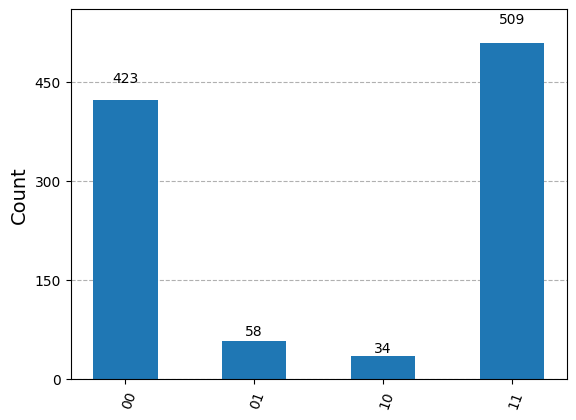

In [ ]:
from qiskit.visualization import plot_histogram # Import plot_histogram
plot_histogram(counts)